In [30]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [31]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [32]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='training')

validation = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 8266 files for training.
Found 10332 files belonging to 2 classes.
Using 2066 files for validation.


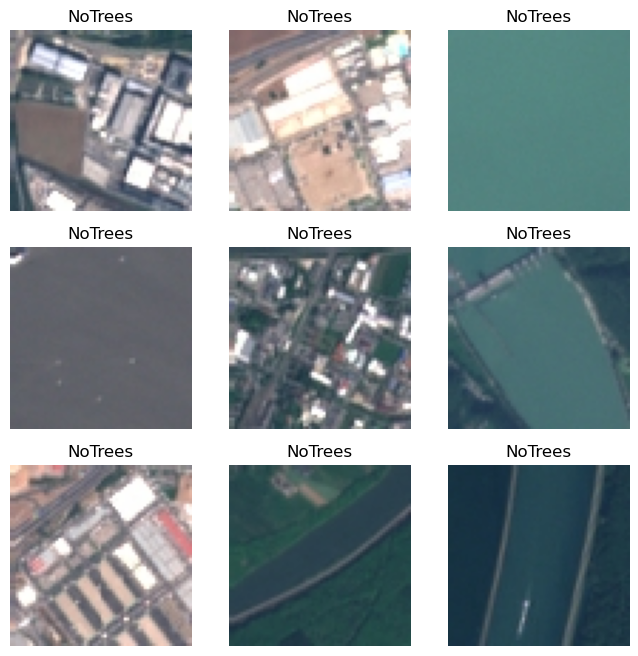

In [33]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [34]:
#split the validation dataset into validation and test datasets
val_batches = tf.data.experimental.cardinality(validation)
test_ds = validation.take(val_batches // 5) #test set
validation_ds = validation.skip(val_batches // 5) #validation set

In [35]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 104
Number of test batches: 26


In [36]:
# performance configuration: Use buffered prefetching to load images from disk
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

I will use transfer learning with a pre-trained network as a starting point for this classification task, and compare to the from-scratch networks that I built. The idea behind transfer learning for image classification is that if a model is trained on a large, general dataset, it will effectively serve as a generic model that can then be applied to other datasets by allowing you to take advantage of these learned feature maps. I first tried using the MobileNet V2 model developed by Google, which is pre-trained on the ImageNet dataset (1.4M images, 1000 classes). This Notebook will try ResNet50

The ResNet50 model expects pixel values from [-1,1] instead of the [0,255] that the images are in currently. So I will first need to rescale them:

In [37]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [38]:
# Create the base model from the pre-trained model ResNet50
from tensorflow.keras.applications import ResNet50
img_size = (64,64)
img_shape = img_size + (3,)
base_model = ResNet50(input_shape=img_shape, include_top=False, weights='imagenet')

In [39]:
# convert each image into a block of features
image_batch, label_batch = next(iter(training))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 2, 2, 2048)


In [40]:
# Freeze the convolutional base before compiling and training the model. This prevents the weights
# in a given layer from being updated before training. 
base_model.trainable = False

In [41]:
# Let's see the base model's summary
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [42]:
# generate predictions from the block of features by averaging over the 2x2 spatial locations, 
# using a GlobalAveragePooling2D layer to convert the features to a single 
# 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [43]:
# Apply a Dense layer to convert these features into a single prediction per image. 
# no activation function here because this prediction will be treated as a logit (raw prediction value)
#Positive numbers predict class 1, negative numbers class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [44]:
#build a model with rescaling, basemodel, and feature extrator layers
inputs = tf.keras.Input(shape=img_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [45]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [47]:
len(model.trainable_variables)

2

The 23.6 million ResNet50 parameters are frozen but there are about 2000 trainable parameters in the Dense output layer (divided between 2 tf variable objects -  weights and biases).

In [48]:
#train the model for 10 epochs
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

130/130 [==============================] - 27s 196ms/step - loss: 1.0645 - accuracy: 0.5382
initial loss: 1.06
initial accuracy: 0.54


In [49]:
from time import time
start = time()

history = model.fit(training,
                    epochs=initial_epochs,
                    validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/10
517/517 [==============================] - 155s 295ms/step - loss: 0.4833 - accuracy: 0.7876 - val_loss: 0.2517 - val_accuracy: 0.9071
Epoch 2/10
517/517 [==============================] - 154s 298ms/step - loss: 0.2498 - accuracy: 0.9141 - val_loss: 0.1662 - val_accuracy: 0.9448
Epoch 3/10
517/517 [==============================] - 156s 301ms/step - loss: 0.1845 - accuracy: 0.9376 - val_loss: 0.1309 - val_accuracy: 0.9608
Epoch 4/10
517/517 [==============================] - 164s 317ms/step - loss: 0.1550 - accuracy: 0.9475 - val_loss: 0.1102 - val_accuracy: 0.9690
Epoch 5/10
517/517 [==============================] - 124s 240ms/step - loss: 0.1295 - accuracy: 0.9596 - val_loss: 0.0969 - val_accuracy: 0.9700
Epoch 6/10
517/517 [==============================] - 120s 233ms/step - loss: 0.1138 - accuracy: 0.9629 - val_loss: 0.0869 - val_accuracy: 0.9743
Epoch 7/10
517/517 [==============================] - 120s 232ms/step - loss: 0.1045 - accuracy: 0.9650 - val_loss: 0.0800 -

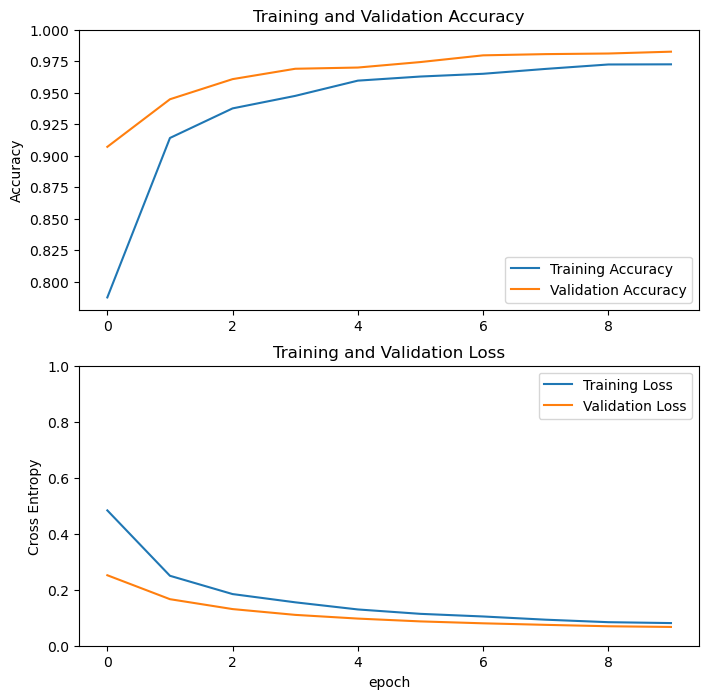

In [51]:
#plot training and validation learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In this feature extraction model, I only added a dense output layer to the ResNet50 model, and the weights of the pre-trained model were not updated during training. Training time was considerably longer with the ResNet50 model compared to MobileNetV2. It achieved about 97% training and validation accuracy and about 0.06 validation loss.

Next, I will take a look at fine-tuning the weights of the top layers of the pretrained model also. This will change the weights to being tuned to generic feature maps to maps of features more specifically associated with the forest satellite image dataset.

In [22]:
# So I will unfreeze the base model so that I can fine tune a few top layers. 
base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [24]:
# Fine-tune from this layer onwards
fine_tune_at = 165

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Before compiling the new model, I will change the learning rate to 0.00001. A lower learning rate is important to not overfit too quickly when training a much larger model than the previous feature extraction model.

In [25]:
#use a lower learning rate

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

start = time()

history_finetuned = model.fit(training,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 10/20
517/517 [==============================] - 264s 502ms/step - loss: 0.0617 - accuracy: 0.9787 - val_loss: 0.0531 - val_accuracy: 0.9869
Epoch 11/20
517/517 [==============================] - 278s 538ms/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 0.0502 - val_accuracy: 0.9811
Epoch 12/20
517/517 [==============================] - 384s 742ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0449 - val_accuracy: 0.9874
Epoch 13/20
517/517 [==============================] - 300s 580ms/step - loss: 0.0118 - accuracy: 0.9966 - val_loss: 0.0449 - val_accuracy: 0.9860
Epoch 14/20
517/517 [==============================] - 277s 535ms/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0458 - val_accuracy: 0.9884
Epoch 15/20
517/517 [==============================] - 294s 568ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.0480 - val_accuracy: 0.9874
Epoch 16/20
517/517 [==============================] - 275s 532ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0

In [27]:
def plot_learning_curve(history):
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.plot(tr_loss, label="Training Loss", color='blue')
    plt.plot(val_loss, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim([0,1.0])
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot the train and val accuracy
    plt.subplot(1,2,2)
    plt.plot(tr_acc, label="Training Accuracy", color='blue')
    plt.plot(val_acc, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.8,1])
    plt.legend()
    plt.title("Training and Validation Accuracy")         

    # Show the figure
    plt.show()

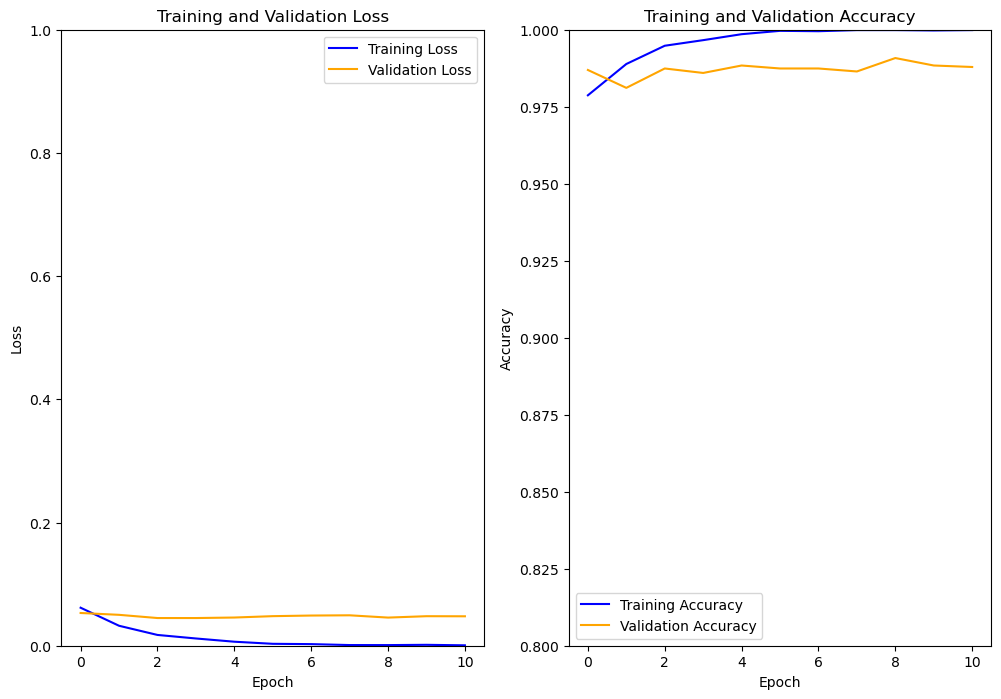

In [29]:
fine_tuned_plots = plot_learning_curve(history_finetuned)

So validation loss and accuracy are definitely improved from the feature extractor model, at close to 100% training and validation accuracy. But training took a very long time, around 48 minutes, by training the top 10 layers. Let's try fine tuning only the 4 top layers and see if that gives a good trade off between accuracy and training time.

In [52]:
base_model.trainable = True

In [53]:
# Fine-tune from this layer onwards
fine_tune_at = 171

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [54]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [55]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

start = time()

history_finetuned_2 = model.fit(training,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 10/20
517/517 [==============================] - 149s 283ms/step - loss: 0.0734 - accuracy: 0.9728 - val_loss: 0.0600 - val_accuracy: 0.9840
Epoch 11/20
517/517 [==============================] - 176s 341ms/step - loss: 0.0649 - accuracy: 0.9793 - val_loss: 0.0570 - val_accuracy: 0.9831
Epoch 12/20
517/517 [==============================] - 178s 344ms/step - loss: 0.0580 - accuracy: 0.9802 - val_loss: 0.0543 - val_accuracy: 0.9850
Epoch 13/20
517/517 [==============================] - 177s 343ms/step - loss: 0.0514 - accuracy: 0.9827 - val_loss: 0.0519 - val_accuracy: 0.9860
Epoch 14/20
517/517 [==============================] - 178s 344ms/step - loss: 0.0475 - accuracy: 0.9850 - val_loss: 0.0504 - val_accuracy: 0.9860
Epoch 15/20
517/517 [==============================] - 190s 368ms/step - loss: 0.0443 - accuracy: 0.9852 - val_loss: 0.0500 - val_accuracy: 0.9860
Epoch 16/20
517/517 [==============================] - 172s 333ms/step - loss: 0.0429 - accuracy: 0.9861 - val_loss: 0

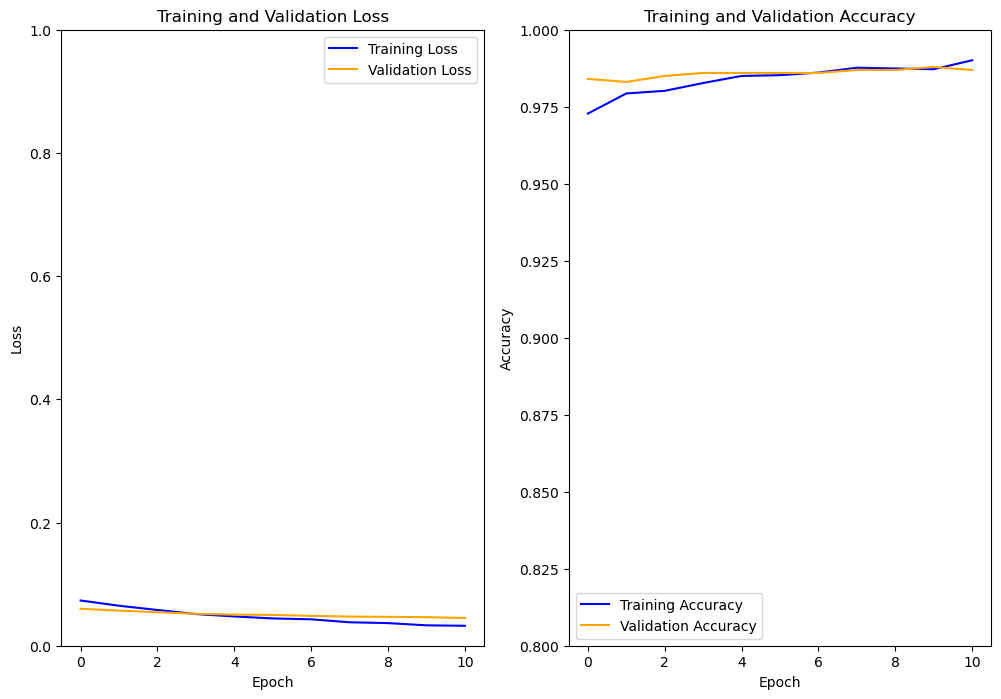

In [56]:
fine_tuned_plots_2 = plot_learning_curve(history_finetuned_2)

So fine-tuning the weights of the top 4 layers was considerably faster (~26 minutes vs 48 minutes) than training the weights of the top 10 layers, and leads to validation accuracy about 98.4% and validation loss around 0.04 to 0.05. This is still over twice the training time for only slightly better accuracy compared to the MobileNetV2 model.

In [35]:
# Fine-tune from this layer onwards
fine_tune_at = 171

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

start = time()

history_finetuned_3 = model.fit(training,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 10/20
517/517 [==============================] - 148s 280ms/step - loss: 7.3284e-05 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 0.9894
Epoch 11/20
517/517 [==============================] - 138s 267ms/step - loss: 3.8670e-05 - accuracy: 1.0000 - val_loss: 0.0577 - val_accuracy: 0.9903
Epoch 12/20
517/517 [==============================] - 132s 255ms/step - loss: 3.7851e-05 - accuracy: 1.0000 - val_loss: 0.0589 - val_accuracy: 0.9874
Epoch 13/20
517/517 [==============================] - 153s 295ms/step - loss: 1.9656e-05 - accuracy: 1.0000 - val_loss: 0.0615 - val_accuracy: 0.9879
Epoch 14/20
517/517 [==============================] - 172s 332ms/step - loss: 1.9832e-05 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9894
Epoch 15/20
517/517 [==============================] - 173s 334ms/step - loss: 1.2642e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9879
Epoch 16/20
517/517 [==============================] - 160s 309ms/step - loss: 1.3212e-05 - ac

In [29]:
model.save("Forest_ResNet50_Transfer_Model")

INFO:tensorflow:Assets written to: Forest_ResNet50_Transfer_Model\assets


INFO:tensorflow:Assets written to: Forest_ResNet50_Transfer_Model\assets


In [30]:
# use the saved model to reconstruct the model identically.
reconstructed_model = keras.models.load_model("Forest_ResNet50_Transfer_Model")

In [31]:
predictions = reconstructed_model.evaluate(x=test_ds, return_dict=True)
# Apply a sigmoid since the model returns logits
#predictions = tf.nn.sigmoid(predictions)
#predictions = tf.where(predictions < 0.5, 0, 1) #assign class 0 if probability less than 0.5, otherwise class 1
#predictions = list(predictions.numpy())

26/26 [==============================] - 6s 189ms/step - loss: 0.0581 - accuracy: 0.9808


So, the final model achieves about 98% accuracy on the rather small test set, which is just slightly worse than on the validation set. Let's view some of the images that the model mislabeled from the test set:



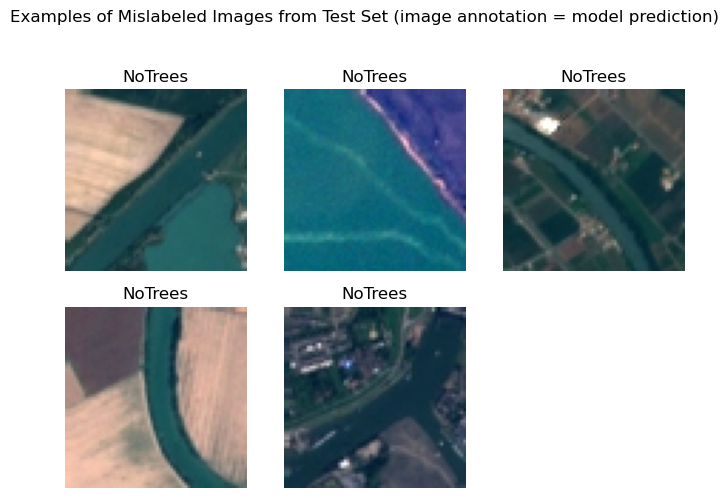

In [60]:
mislabeled_img = []
mislabeled_pred = []
mislabeled_class = []
preds = []
test_labels = []
images=[]

# There are 26 batches in the test set. 
# Take enough batches to be sure to get at least 9 mislabeled images.

for imgs, labels in test_ds.take(26): 
    
    batch_preds = model.predict(imgs, verbose = 0)

    test_labels = [int(x) for x in test_labels]

    # Apply a sigmoid since the model returns logits
    batch_preds = tf.nn.sigmoid(batch_preds)
    batch_preds = tf.where(batch_preds < 0.5, 0, 1) #assign class 0 if probability less than 0.5, otherwise class 1
    batch_preds = list(batch_preds.numpy()) #to get predictions in same format as labels
    preds.extend(batch_preds)
    test_labels.extend(labels)

    for j in range(len(imgs)):
        images.append(tf.keras.utils.array_to_img(imgs[j]))

index_list = [] 

for i in range(len(test_labels)):
    if test_labels[i] != preds[i]:
        index_list.append(i)
        mislabeled_pred.append(preds[i])
        mislabeled_class.append(test_labels[i])

#print(f"Predicted Label:    {mislabeled_pred}")
#print(f"Actual Class Label: {mislabeled_class}")

plt.figure(figsize=(8, 8))
for i in range(len(index_list)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[index_list[i]])
    plt.title(class_names[np.argmax(mislabeled_class[i], axis=None, out=None)])
    plt.axis("off")
    plt.suptitle("Examples of Mislabeled Images from Test Set (image annotation = model prediction)")

It is evident from the example mislabeled images that the model has a hard time correctly predicting Trees in the case of rivers that also contain trees and images of pasture land that happen to also have some trees in them. Some of the training images are of type 'AnnualCrop' and 'Pasture', which are classified as NoTrees and Trees, repsectively. The AnnualCrop are images of industrial or large scale agriculture with no trees, and the Pasture images are natural pastureland that do contian trees. In some cases the AnnualCrop and Pasture do appear very similar and the model misses some of these.